In [1]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook as fastb
fastb.setup_book()

# Other Computer Vision Problems

## Multi-Label Classification

### The Data

In [3]:
#
path = fastb.untar_data(fastb.URLs.PASCAL_2007)

In [4]:
import pandas as pd
df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


### Sidebar: Pandas and DataFrames

In [5]:
#
# look at all the columns in a row
df.iloc[0,:]
# Trailing :s are always optional (in numpy, pytorch, pandas, etc.),
#   so this is equivalent:
df.iloc[0]

fname       000005.jpg
labels           chair
is_valid          True
Name: 0, dtype: object

In [6]:
#
# look at a single column
df['fname']

0       000005.jpg
1       000007.jpg
2       000009.jpg
3       000012.jpg
4       000016.jpg
           ...    
5006    009954.jpg
5007    009955.jpg
5008    009958.jpg
5009    009959.jpg
5010    009961.jpg
Name: fname, Length: 5011, dtype: object

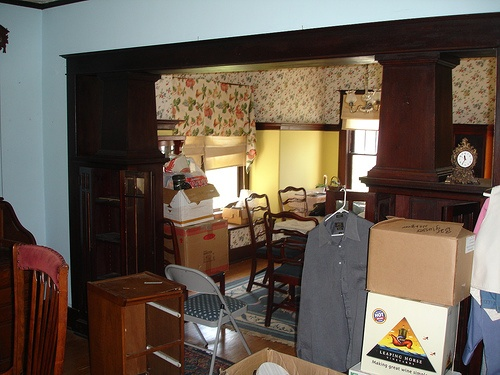

In [8]:
fpath = path / "train" / df['fname'][0]
fpath.exists()
fastb.Image.open(fpath)
#print(df['labels'][0])

### Constructing a DataBlock

In [9]:
dblock = DataBlock()

In [10]:
# df is dataframe of JUST tuples from train.csv
dsets = dblock.datasets(df)

In [11]:
len(dsets.train),len(dsets.valid)

(4009, 1002)

In [12]:
x,y = dsets.train[0]
x,y

(fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object,
 fname       008663.jpg
 labels      car person
 is_valid         False
 Name: 4346, dtype: object)

In [13]:
x['fname']

'008663.jpg'

In [14]:
#
# silly example
# create datasets from Datablock based on dataframe
dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('005620.jpg', 'aeroplane')

In [15]:
#
# another silly example
def get_x(r): return r['fname']
def get_y(r): return r['labels']
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

('002549.jpg', 'tvmonitor')

In [16]:
#
# set up DataBlock w/ working functions to extract fname and
# labels from each dataframe row
def get_x(r): 
    return path/'train'/r['fname']   # full fname path
def get_y(r): 
    return r['labels'].split(' ')
dblock = DataBlock(get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(Path('/root/.fastai/data/pascal_2007/train/002844.jpg'), ['train'])

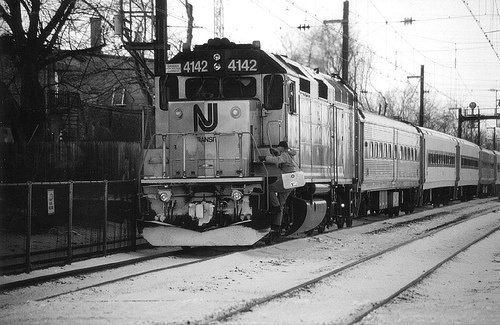

In [17]:
Image.open(dsets.train[0][0])

In [18]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x, get_y = get_y)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]))

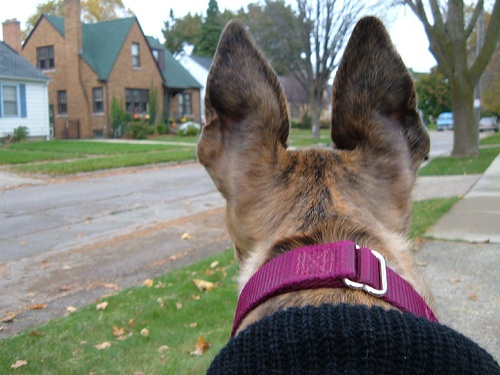

In [19]:
dsets.train[0][0]

In [21]:
idxs = torch.where(dsets.train[0][1]==1.)[0]
w = torch.where(dsets.train[0][1]==1.)
print(type(w[0]))
print((w[0]).tolist())
idxs=[0, 1,3]
print(dsets.train.vocab[idxs]  )

# how did vocab[] get assigned?
# get_y splits label string into a list of strings; multicategory block turns this into one-hot
# and (presumably) assigns vocab

<class 'fastai.torch_core.TensorMultiCategory'>
[11]
['aeroplane', 'bicycle', 'boat']


In [22]:
def print_labels(onehot, dset):
    idx_tuple = torch.where(onehot==1.0)  # output is a tuple of size 1
    idx = idx_tuple[0].tolist()  # idx_tuple[0] is a TensorMultiCategory object
    print(idx)
    print(dset.train.vocab[idx])

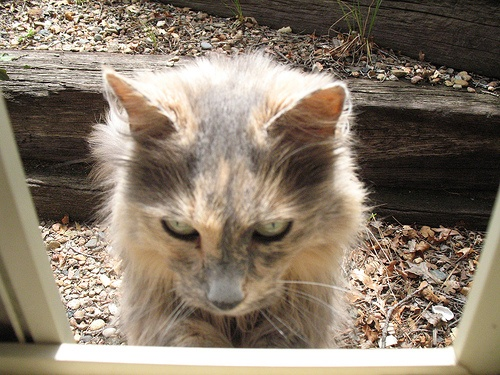

In [24]:
dsets.train[100][0]

In [23]:
print_labels(dsets.train[100][1], dsets)

[7]
['cat']


In [25]:
df['is_valid'][0:10]

0     True
1     True
2     True
3    False
4     True
5    False
6     True
7     True
8     True
9    False
Name: is_valid, dtype: bool

In [26]:
#
# replace random splitter (for train/valid set) with splitter based on 'is_valid' column
def splitter(df):
    train = df.index[~df['is_valid']].tolist()
    valid = df.index[df['is_valid']].tolist()
    return train,valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y)

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]))

In [27]:
[len(dsets.train), len(dsets.valid)]

[2501, 2510]

In [28]:
#dsets.train[][1]
dsets.train[1000][1]

print_labels(dsets.train[1001][1], dsets)

[6]
['car']


In [29]:
#
# normalize images w/ crop & rescale
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=splitter,
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)

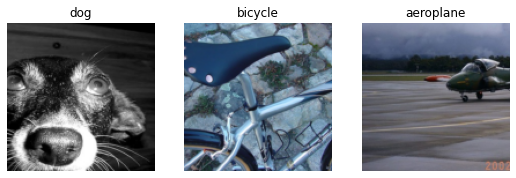

In [30]:
dls.show_batch(nrows=1, ncols=3)

### Binary Cross-Entropy

In [31]:
learn = vision_learner(dls, resnet18)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [33]:
x,y = to_cpu(dls.train.one_batch()) # why???
#x,y = dls.train.one_batch()   # this doesnt work
# https://forums.fast.ai/t/chapter-6-runtimeerror-input-type-and-weight-type-should-be-the-same/83710

activs = learn.model(x)
activs.shape

torch.Size([64, 20])

In [34]:
activs[0]

TensorBase([ 0.5674, -1.2013,  4.5409, -1.5284, -0.6600,  0.0999, -2.4757, -0.8773, -0.2934, -1.4746, -0.1738,  2.1763, -3.4473, -1.1407,  0.1783, -1.6922, -2.3396,  0.7602, -1.4213, -0.4334],
           grad_fn=<AliasBackward0>)

In [35]:
def binary_cross_entropy(inputs, targets):
    inputs = inputs.sigmoid()
    return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [36]:
loss_func = nn.BCEWithLogitsLoss()
loss = loss_func(activs, y)
loss

TensorMultiCategory(1.0367, grad_fn=<AliasBackward0>)

In [37]:
def say_hello(name, say_what="Hello"): return f"{say_what} {name}."
say_hello('Jeremy'),say_hello('Jeremy', 'Ahoy!')

('Hello Jeremy.', 'Ahoy! Jeremy.')

In [38]:
f = partial(say_hello, say_what="Bonjour")
f("Jeremy"),f("Sylvain")

('Bonjour Jeremy.', 'Bonjour Sylvain.')

In [39]:
#
# replace accuracy_multi function with partial(accuracy_multi, thresh=0.2)
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, thresh=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.941279,0.691004,0.239841,00:14
1,0.826683,0.566812,0.280896,00:09
2,0.601593,0.203737,0.820438,00:09
3,0.360826,0.123823,0.945478,00:09


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.130999,0.117014,0.947610,00:12
1,0.117188,0.106831,0.951733,00:11
2,0.097658,0.102161,0.952829,00:12


In [44]:
# don't set threshold too low
learn.metrics = partial(accuracy_multi, thresh=0.1)
learn.validate()  # output is [loss, metrics]

(#2) [0.10216096043586731,0.930956244468689]

In [45]:
#
# don't set threshold too high
learn.metrics = partial(accuracy_multi, thresh=0.99)
learn.validate() # output is [loss, metrics]

(#2) [0.10216096043586731,0.9424103498458862]

In [46]:
preds,targs = learn.get_preds()

In [48]:
#
# sigmoid=false: don't apply sigmoid
accuracy_multi(preds, targs, thresh=0.9, sigmoid=False)

TensorBase(0.9573)

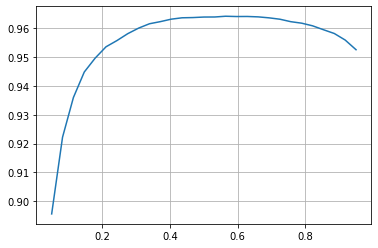

In [50]:
# find best threshold
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.plot(xs,accs);
plt.grid()

## Regression

### Assemble the Data

In [51]:
path = untar_data(URLs.BIWI_HEAD_POSE)

In [52]:
#hide
Path.BASE_PATH = path

In [53]:
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [54]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [55]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('16/frame_00831_pose.txt')

In [56]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

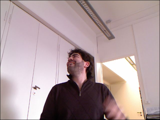

In [57]:
im.to_thumb(160)

In [65]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):  
    """get (x,y) center of image"""
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [66]:
get_ctr(img_files[0])

tensor([312.9687, 239.5307])

In [71]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y = get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320) ),
                Normalize.from_stats(*imagenet_stats)]
)
    

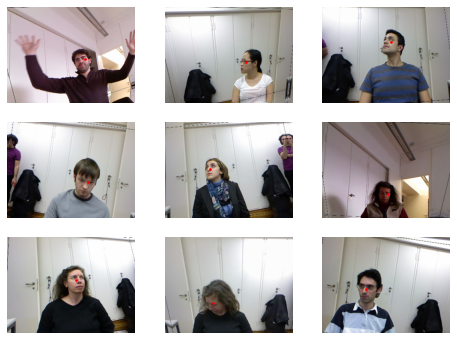

In [72]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [75]:
xb,yb = dls.one_batch()
xb.shape,yb.shape

#
# one batch of xb is 64 images of (3, 240, 320)
#              yb is 64 coordinates (x,y)

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [76]:
yb[0]

TensorPoint([[0.2706, 0.3769]], device='cuda:0')

### Training a Model

In [77]:
learn = vision_learner(dls, resnet18, y_range=(-1,1))

In [ ]:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

In [ ]:
plot_function(partial(sigmoid_range,lo=-1,hi=1), min=-4, max=4)

In [ ]:
dls.loss_func

In [ ]:
learn.lr_find()

In [ ]:
lr = 1e-2
learn.fine_tune(3, lr)

In [ ]:
math.sqrt(0.0001)

In [ ]:
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))

## Conclusion

## Questionnaire

1. How could multi-label classification improve the usability of the bear classifier?
1. How do we encode the dependent variable in a multi-label classification problem?
1. How do you access the rows and columns of a DataFrame as if it was a matrix?
1. How do you get a column by name from a DataFrame?
1. What is the difference between a `Dataset` and `DataLoader`?
1. What does a `Datasets` object normally contain?
1. What does a `DataLoaders` object normally contain?
1. What does `lambda` do in Python?
1. What are the methods to customize how the independent and dependent variables are created with the data block API?
1. Why is softmax not an appropriate output activation function when using a one hot encoded target?
1. Why is `nll_loss` not an appropriate loss function when using a one-hot-encoded target?
1. What is the difference between `nn.BCELoss` and `nn.BCEWithLogitsLoss`?
1. Why can't we use regular accuracy in a multi-label problem?
1. When is it okay to tune a hyperparameter on the validation set?
1. How is `y_range` implemented in fastai? (See if you can implement it yourself and test it without peeking!)
1. What is a regression problem? What loss function should you use for such a problem?
1. What do you need to do to make sure the fastai library applies the same data augmentation to your input images and your target point coordinates?

### Further Research

1. Read a tutorial about Pandas DataFrames and experiment with a few methods that look interesting to you. See the book's website for recommended tutorials.
1. Retrain the bear classifier using multi-label classification. See if you can make it work effectively with images that don't contain any bears, including showing that information in the web application. Try an image with two different kinds of bears. Check whether the accuracy on the single-label dataset is impacted using multi-label classification.